# Hands-on CamemBERT

This tutorial is presented by Roman Castagné, Nathan Godey et Benjamin Muller, available on [here](https://camembert-model.fr/posts/tutorial/).

- Our task is to build a **dialogue act classification model for French**. To do so, **tokenisation** is the first step of almost every task in NLP. It means to segment raw text to define our modeling units (tokens). 
- **Sentencepiece tokenisation** is the method we chose because it's the tradeoff between word-level segmentation (out-of-vocabulary problem) and character-level segmentation (too longe sequences), it refers to segment the text at the word-level, except for infrequent words that are segmented for subword level. (ex. 'plasturgie' -> 'plast','ur','ie') 
- To parametrize the model, we use the **transformer architecture**, which is a deep learning architecture, it can be parametrized in any sequence modelling, classification and generation tasks. Tranformer architecture is the most popular and accurate for most NLP tasks.

Tools : 
- `transformers` from Hugging Face
- `pytorch-lightning`

In [33]:
! pip install transformers plotly==5.8.0 pyyaml==5.4.1 datasets pytorch-lightning > /dev/null 2>&1

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [34]:
! pip install torch

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [35]:
from pprint import pprint
import functools

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pytorch_lightning as pl
from transformers import AutoModelForSequenceClassification, CamembertForMaskedLM, AutoTokenizer, AutoConfig
from datasets import load_dataset
from sklearn.metrics import confusion_matrix, f1_score

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tqdm.notebook import tqdm

## Part 1 : Understand CamemBERT model  

### I. How does camemBERT model works

Install camemBERT model from HuggingFace, an online free library containing pretrained models and datasets. Some architectures and datasets are available thanks to research teams work. 

In [36]:
camembert = CamembertForMaskedLM.from_pretrained('camembert-base')

CamemBERT is a transformer-type model that can process sequences in which elements are interdependent like word in a sentence, for example. CamemBERT-base (basic version of the model) is composed of :
- 1 **embedding layer** to represent every word to vector
- 12 **hidden layers** of 2 transformation types: 
    - self-attention transformation
    - dense transformation

![image-camemBERT](images/camemBERT.png)


In [37]:
# Visualiser la couches d'embeddings
camembert.roberta.embeddings

CamembertEmbeddings(
  (word_embeddings): Embedding(32005, 768, padding_idx=1)
  (position_embeddings): Embedding(514, 768, padding_idx=1)
  (token_type_embeddings): Embedding(1, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

Roberta embeddings layer stores 32005 vectors of 768 dimensions (word embeddings). Every vector is associated to a word in vocabulary (which means 32005 words in vocabulary).

In [38]:
print(f"Camembert is composed of {len(camembert.roberta.encoder.layer)} hidden layers\n")
print("Composition of 1st layer :")
camembert.roberta.encoder.layer[0]

Camembert is composed of 12 hidden layers

Composition of 1st layer :


CamembertLayer(
  (attention): CamembertAttention(
    (self): CamembertSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): CamembertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): CamembertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): CamembertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In most layers, vectors have 768 dimensions. We call it **hidden dimension** of the model. 

We can also calculate the total weight of model in MB.

In [39]:
def display_nb_params(model):
    param_size = 0
    param_count = 0
    for param in model.parameters():
        param_count += param.nelement()
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024**2
    print('Nombre de paramètres: {} | Poids du modèle: {:.2f}MB'.format(param_count, size_all_mb))

display_nb_params(camembert)

Nombre de paramètres: 110655493 | Poids du modèle: 422.13MB


### II. Make predictions with CamemBERT

CamemBERT is pretrained with a task named **Masked Language Modelling**. Some words in sequences are masked and we need to predict them with the associated context (other no-masked words in the sequences).

This task can be divided into 2 steps : 
1. Tokenize sequences using **sentencepiece algorithm** (every sentence is converted to word-form or subword-form tokens).
2. Every token is identified with a integer corresponding to its position in the vocabulary (**input_ids**) and a mask indicating the tokens that need to be attentioned (**attention_mask**). 

In [40]:
batch_sentences = [
    "Vous savez où est la <mask> la plus proche?",
    "La Seine est un <mask>.",
    "Je cherche urgemment un endroit où retirer de l'<mask>.",
]

In [41]:
tokenizer = AutoTokenizer.from_pretrained('camembert-base')
tokenizer_output = tokenizer(batch_sentences)
pprint(tokenizer_output, width = 150)

{'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
 'input_ids': [[5, 158, 2591, 147, 30, 13, 32004, 13, 40, 1084, 197, 6],
               [5, 61, 4458, 30, 23, 32004, 21, 9, 6],
               [5, 100, 1066, 21, 20090, 10256, 23, 1643, 147, 4384, 8, 17, 11, 32004, 21, 9, 6]]}


Let's take a look about what we get exactly in `input_ids`: 

- space => `_`
- start of sequence => `<s>`
- end of sequence => `</s>`

In [42]:
pprint([tokenizer.convert_ids_to_tokens(input_ids) for input_ids in tokenizer_output['input_ids']], width = 150)

[['<s>', '▁Vous', '▁savez', '▁où', '▁est', '▁la', '<mask>', '▁la', '▁plus', '▁proche', '?', '</s>'],
 ['<s>', '▁La', '▁Seine', '▁est', '▁un', '<mask>', '▁', '.', '</s>'],
 ['<s>', '▁Je', '▁cherche', '▁', 'urge', 'mment', '▁un', '▁endroit', '▁où', '▁retirer', '▁de', '▁l', "'", '<mask>', '▁', '.', '</s>']]


As transformer layers in camemBERT process a fixed number for sequence length (512 in this case), we need to add padding tokens to complete sequences and we call this step as `padding`. 


`Attention_masks` store padding token position in memory of every sequence. We also need to assure that no sequence exceeds this limit of 512 tokens. To do this, we change simply a parameter of tokenizer : `truncation = True`.

Then we need PyTorch to perform vector and latrix calculations. We need to convert tokenizer output to `torch.Tensor` using `return_tensors = 'pt'`. 

In [43]:
tokenizer_output = tokenizer(
    batch_sentences,
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)
pprint(tokenizer_output, width=150)

{'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]),
 'input_ids': tensor([[   5,  158, 2591,  ...,    1,    1,    1],
        [   5,   61, 4458,  ...,    1,    1,    1],
        [   5,  100, 1066,  ...,    1,    1,    1]])}


Preprocessing is done ! We can then give it to model input. 

In [44]:
with torch.no_grad():
    model_output = camembert(**tokenizer_output, output_hidden_states=True)
    model_output

In order to predict the masked word, we need softmax function (using PyTorch) to predict the probability of every token as model output. 

![softmax](images/softmax.png)

In [45]:
def get_probas_from_logits(logits):
    return logits.softmax(-1)

def visualize_mlm_predictions(tokenizer_output, model_output, tokenizer, nb_candidates=10):
    # Decode the tokenized sentences and clean-up the special tokens
    decoded_tokenized_sents = [sent.replace('<pad>', '').replace('<mask>', ' <mask>') for sent in tokenizer.batch_decode(tokenizer_output.input_ids)]

    # Retrieve the probas at the masked positions
    masked_tokens_mask = tokenizer_output.input_ids == tokenizer.mask_token_id
    batch_mask_probas = get_probas_from_logits(model_output.logits[masked_tokens_mask])

    for sentence, mask_probas in zip(decoded_tokenized_sents, batch_mask_probas):
        # Get top probas and plot them
        top_probas, top_token_ids = mask_probas.topk(nb_candidates, -1)
        top_tokens = tokenizer.convert_ids_to_tokens(top_token_ids)
        bar_chart = px.bar({"tokens": top_tokens[::-1], "probas": list(top_probas)[::-1]},
                        x="probas", y="tokens", orientation='h', title=sentence, width=800)
        bar_chart.show(config={'staticPlot': True})

visualize_mlm_predictions(tokenizer_output, model_output, tokenizer)

### III. Sentence representation with camemBERT

As we've already known in camemBERT, every token is associated with an embedding, which is a 768-dimension vector. We can get these embeddings like this :

In [46]:
token_embeddings = model_output.hidden_states[-1]

We present 2 different ways to represent a sentence (means a sequence of tokens) with these token embeddings.

1. extract first token's embeddings > `take_first_embedding`
2. calculate the average embedding of all tokens in sequence > `average_embedding`

In [47]:
def take_first_embedding(embeddings, attention_mask=None):
    return embeddings[:, 0]

def average_embeddings(embeddings, attention_mask):
    return (attention_mask[..., None] * embeddings).mean(1)

In [48]:
first_tok_sentence_representations = take_first_embedding(token_embeddings, tokenizer_output.attention_mask)
avg_sentence_representations = average_embeddings(token_embeddings, tokenizer_output.attention_mask)

first_tok_sentence_representations.shape, avg_sentence_representations.shape

(torch.Size([3, 768]), torch.Size([3, 768]))

Then we can calculate the similarity of these two representations using **cosine similarity distance**, which can give us a general idea of semantic similarity between two sentences. The value varies from -1 to 1, indicating the angular difference between 2 embeddings.

In [49]:
for sent_id_1, sent_id_2 in [[0, 1], [2, 1], [2, 0]]:
    first_tok_similarity_score = F.cosine_similarity(first_tok_sentence_representations[sent_id_1], first_tok_sentence_representations[sent_id_2], dim = -1)
    avg_similarity_score = F.cosine_similarity(avg_sentence_representations[sent_id_1], avg_sentence_representations[sent_id_2], dim = -1)

    print(f"{batch_sentences[sent_id_1]}    vs.    {batch_sentences[sent_id_2]}")
    print(f"Score (first_tok) : {first_tok_similarity_score}")
    print(f"Score (average) : {avg_similarity_score}\n")

Vous savez où est la <mask> la plus proche?    vs.    La Seine est un <mask>.
Score (first_tok) : 0.9248183965682983
Score (average) : 0.8208714127540588

Je cherche urgemment un endroit où retirer de l'<mask>.    vs.    La Seine est un <mask>.
Score (first_tok) : 0.9264646172523499
Score (average) : 0.8607448935508728

Je cherche urgemment un endroit où retirer de l'<mask>.    vs.    Vous savez où est la <mask> la plus proche?
Score (first_tok) : 0.9239857196807861
Score (average) : 0.8845345377922058



We note that the approach of choosing the embedding of the first token to represent a sentence does not allow us to differentiate the levels of similarity between sentences. For inference purposes, we therefore **prefer to average the embeddings**, which gives a greater similarity between the semantically closest sentences.

### IV. Application to chat messages

We choose a French dataset MIAM, which groups messages extracted from a chat platform, with labels describing the message's specific intention. The dataset is available on Hugging Face that can be downloaded using `load_dataset` function. Then we can convert it to `pandas.DataFrame`. 

In [50]:
dataset = load_dataset("miam", "loria")
dataset

Found cached dataset miam (/Users/wq/.cache/huggingface/datasets/miam/loria/1.0.0/3cb25c5337f9e60db1dc6d90344763a6ef79d7a4ac3c5f215ce6e8afe99db26c)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Speaker', 'Utterance', 'Dialogue_Act', 'Dialogue_ID', 'File_ID', 'Label', 'Idx'],
        num_rows: 8465
    })
    validation: Dataset({
        features: ['Speaker', 'Utterance', 'Dialogue_Act', 'Dialogue_ID', 'File_ID', 'Label', 'Idx'],
        num_rows: 942
    })
    test: Dataset({
        features: ['Speaker', 'Utterance', 'Dialogue_Act', 'Dialogue_ID', 'File_ID', 'Label', 'Idx'],
        num_rows: 1047
    })
})

In [51]:
pd_dataset = {split_name: split_data.to_pandas() for split_name, split_data in dataset.items()}
pd_dataset["validation"]

,Speaker,Utterance,Dialogue_Act,Dialogue_ID,File_ID,Label,Idx
0,Samir,Bravo! Vous avez été rapides!,greet,19,Dial_20110530_154627,5,0
1,Samir,Qu'est-ce que je peux faire pour vous?,ask,19,Dial_20110530_154627,1,1
2,Julie,merci,next_step,19,Dial_20110530_154627,17,2
3,Samir,"Eh bien, il va falloir la fabriquer cette mane...",inform,19,Dial_20110530_154627,7,3
4,Samir,"Mais sinon, vous avez encore des questions sur...",ask,19,Dial_20110530_154627,1,4
...,...,...,...,...,...,...,...
937,Julie,Avec plaisir!,yes,1239,Dial_20120104_160514,30,937
938,Sophia,C' est un métier pour lequel il faut être poly...,inform,1239,Dial_20120104_160514,7,938
939,Julie,"Oui, je vois.",ack,1239,Dial_20120104_160514,0,939
940,Sophia,"Je vous laisse les assembler , je les ai posé ...",quit,1239,Dial_20120104_160514,21,940


We can firstly look at distribution of labels and we can see that the dataset is quite unbalanced. 

/var/folders/zs/8bcplfh522dbbz7dwwqyrlq80000gn/T/ipykernel_11911/627999248.py:8: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



The dataset contains 31 labels.


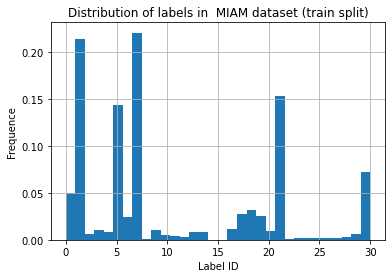

In [52]:
nb_labels = len(pd_dataset["train"]["Label"].unique())
print(f"The dataset contains {nb_labels} labels.")

ax = pd_dataset["train"]["Label"].hist(density=True, bins=nb_labels+1)
ax.set_xlabel("Label ID")
ax.set_ylabel("Frequence")
ax.set_title("Distribution of labels in  MIAM dataset (train split)")
ax.figure.show()

Then we look at the length of the strings and check if they are suitable for camemBERT. We can see that no sentence has passed over 512 tokens. 

/var/folders/zs/8bcplfh522dbbz7dwwqyrlq80000gn/T/ipykernel_11911/2986872962.py:6: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



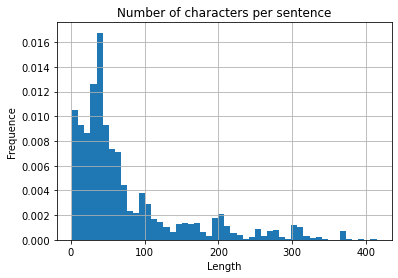

In [53]:
pd_dataset["train"]["len_utt"] = pd_dataset["train"]["Utterance"].apply(lambda x: len(x))
ax = pd_dataset["train"]["len_utt"].hist(density=True, bins=50)
ax.set_xlabel("Length")
ax.set_ylabel("Frequence")
ax.set_title("Number of characters per sentence")
ax.figure.show()

In [54]:
print((pd_dataset["train"]["len_utt"] > 512).any())

False


Next, we can use camemBERT model to get a vector representation for every message. To do so, we call `DataLoader` from `PyTorch` to tokenize all text messages with `collate_fn`.

In [55]:
def tokenize_batch(samples, tokenizer):
    text = [sample["Utterance"] for sample in samples]
    labels = torch.tensor([sample["Label"] for sample in samples])
    str_labels = [sample["Dialogue_Act"] for sample in samples]
    # The tokenizer handles
    # - Tokenization (amazing right?)
    # - Padding (adding empty tokens so that each example has the same length)
    # - Truncation (cutting samples that are too long)
    # - Special tokens (in CamemBERT, each sentence ends with a special token </s>)
    # - Attention mask (a binary vector which tells the model which tokens to look at. For instance it will not compute anything if the token is a padding token)
    tokens = tokenizer(text, padding="longest", return_tensors="pt")

    return {"input_ids": tokens.input_ids, "attention_mask": tokens.attention_mask, "labels": labels, "str_labels": str_labels, "sentences": text}

Let's get 3 splits from the dataset, and create a `DataLoader` for all the validation. 

In [56]:
train_dataset, val_dataset, test_dataset = dataset.values()
val_dataloader = DataLoader(val_dataset, collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer), batch_size=16)
next(iter(val_dataloader))

{'input_ids': tensor([[   5, 6858,  152,  ...,    1,    1,    1],
         [   5, 1034,   11,  ...,    1,    1,    1],
         [   5,  895,    6,  ...,    1,    1,    1],
         ...,
         [   5,   30,   44,  ...,    1,    1,    1],
         [   5,   69,   45,  ...,    1,    1,    1],
         [   5,  159,  178,  ...,    1,    1,    1]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'labels': tensor([ 5,  1, 17,  7,  1, 24,  7,  1, 30,  7, 21,  5,  1, 17,  7,  1]),
 'str_labels': ['greet',
  'ask',
  'next_step',
  'inform',
  'ask',
  'staff_enterprise',
  'inform',
  'ask',
  'yes',
  'inform',
  'quit',
  'greet',
  'ask',
  'next_step',
  'inform',
  'ask'],
 'sentences': ['Bravo! Vous avez été rapides!',
  "Qu'est-ce que je peux faire pour vous?",
  'merci',
  "Eh bien, il va fa

`DataLoader` get batchs of 16 sentences with their labels, then tokenize them and stock in a dictionnary for camemBERT processing. 

We need to iterate in this `DataLoader` in order to get a representation for every sentence in dataset. 

We could use the `.cuda()` method to activate all GPU mode.

In [57]:
sentences = []
labels = []
str_labels = []
all_representations = torch.Tensor()

with torch.no_grad():
    for tokenized_batch in tqdm(val_dataloader):
        model_output = camembert(
            input_ids = tokenized_batch["input_ids"],
            attention_mask = tokenized_batch["attention_mask"],
            output_hidden_states=True
        )
        batch_representations = average_embeddings(model_output["hidden_states"][-1], tokenized_batch["attention_mask"])
        sentences.extend(tokenized_batch["sentences"])
        labels.extend(tokenized_batch["labels"])
        str_labels.extend(tokenized_batch["str_labels"])
        all_representations = torch.cat((all_representations, batch_representations), 0)


  0%|          | 0/59 [00:00<?, ?it/s]

In [58]:
'''
# GPU mode 

camembert = camembert.cuda()

sentences = []
labels = []
str_labels = []
all_representations = torch.tensor([], device='cuda')

with torch.no_grad():
    for tokenized_batch in tqdm(val_dataloader):
        model_output = camembert(
            input_ids = tokenized_batch["input_ids"].cuda(),
            attention_mask = tokenized_batch["attention_mask"].cuda(),
            output_hidden_states=True
        )
        batch_representations = average_embeddings(model_output["hidden_states"][-1], tokenized_batch["attention_mask"].cuda())
        sentences.extend(tokenized_batch["sentences"])
        labels.extend(tokenized_batch["labels"])#
        str_labels.extend(tokenized_batch["str_labels"])
        all_representations = torch.cat((all_representations, batch_representations), 0)

'''

'\n# GPU mode \n\ncamembert = camembert.cuda()\n\nsentences = []\nlabels = []\nstr_labels = []\nall_representations = torch.tensor([], device=\'cuda\')\n\nwith torch.no_grad():\n    for tokenized_batch in tqdm(val_dataloader):\n        model_output = camembert(\n            input_ids = tokenized_batch["input_ids"].cuda(),\n            attention_mask = tokenized_batch["attention_mask"].cuda(),\n            output_hidden_states=True\n        )\n        batch_representations = average_embeddings(model_output["hidden_states"][-1], tokenized_batch["attention_mask"].cuda())\n        sentences.extend(tokenized_batch["sentences"])\n        labels.extend(tokenized_batch["labels"])#\n        str_labels.extend(tokenized_batch["str_labels"])\n        all_representations = torch.cat((all_representations, batch_representations), 0)\n\n'

Now we will visualize these representations and see if clusters appear naturally. 

Recall that camemBERT representations are simply vector outputs (see illustrations below). So we start by projecting representations to 2 dimensions using [TSNE](), then associate every sentence with their label using a color.  


![camem2](images/camem.png)

In [59]:
# Uncomment below to execute (unfortunately tsne crashed on my OS but it worked on googlecolab so I'll just put the result graph below)
# from sklearn.manifold import TSNE
# tsne = TSNE()
# all_representations_2d = tsne.fit_transform(all_representations)
# scatter_plot = px.scatter(x=all_representations_2d[:, 0], y=all_representations_2d[:, 1], color=str_labels)
# scatter_plot.show(config={'staticPlot': True})

![tsne](images/tsne.png)

We can see that a number of clusters can be distinguished, but it's clear that the model's representations can not be correctly classified, so it's important to finetune a general model like camemBERT to accomplish a specific task. 

## Construct a model to a specific NLP task (Dialog act classification) using camemBERT model

### Finetune camemeBERT model for sequence classification 

Recall that the data preparation process is quite simple in our case because of small size of dataset. The preprocessing includes three steps here below :
- sequence tokenization
- padding tokenization so that every sequence has the same length 
- add special token

We will reuse collate function `tokenize_batch` to instantiate a DataLoader which will pass data to the model in batch mode. 

A batch is a group of data passed to training step. Loss and gradient are calculated and averaged over the entire batch. It can avoid a huge variance for gradient in stochastic gradient descent. 

Relook some sentences from our dataset MIAM.

In [60]:
num_labels = dataset["train"].features["Label"].num_classes
pd_dataset["validation"][["Dialogue_Act", "Utterance"]].head(20)

,Dialogue_Act,Utterance
0,greet,Bravo! Vous avez été rapides!
1,ask,Qu'est-ce que je peux faire pour vous?
2,next_step,merci
3,inform,"Eh bien, il va falloir la fabriquer cette mane..."
4,ask,"Mais sinon, vous avez encore des questions sur..."
5,staff_enterprise,j'ai un peu de temps... allez y dites moi en p...
6,inform,"la plasturgie, c' est plus une question de log..."
7,ask,et vous vouliez savoir quelles études ils avai...
8,yes,oui oui
9,inform,Il y a des métiers pour tout le monde du BEP à...


It's important for training model not to take data in the same order over epochs. To avoid this, we use the shuffle argument in the DataLoader.

In [61]:
train_dataloader = DataLoader(
    dataset["train"], 
    batch_size=16, 
    shuffle=True, 
    collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer)
)
val_dataloader = DataLoader(
    dataset["validation"], 
    batch_size=16, 
    shuffle=False, 
    collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer)
)

A nice way of make sure the data that will be trained by the model in a correct format is to take a look at a batch and decode index from the tokenizer. We can observe tokens, and special tokens (`</s>`, `<s>`, `<pad>`).

In [62]:
batch = next(iter(train_dataloader))
print("\n".join(tokenizer.batch_decode(batch["input_ids"])))
batch["labels"]

<s> Oui, les tests sont fait.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
<s> Allez!</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
<s> Faut faire le packaging?</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

tensor([17, 21, 11,  7,  5,  7,  0,  5, 21,  5,  5, 21, 17,  5,  7, 19])

### I. Model preparation

We will use PyTorch Lightning, a PyTorch utility simplified for model training of Machine Learning methods, particularly by deleting training and optimization loops written by hand. To use PL, we will wrap our model in `LightningModule` and implement 3 main methods. 

- `training_step`: take a batch of data for model training and **return a model loss**. We define `CrossEntropy` here.
- `validation_step`: similar to `training_step` but **returns accuracy**, a validation metric that we use.
- `configure_optimizer`: returns optimizer that we wish to use for training step. One of the most used in Tranformer Model is **AdamW**, avaible in `torch.optim`. We fix learning rate when defining optimizer.

Learning rate can adjust step length in every step of optimization. A too-long step avoids to achieve the convergence, but a too-short step will extend training time. 

Cross entropy is a mesure of divergence between model predictions and observed labels. Assume that $y$ is true label and $\hat{y}$ is a score distribued by model at the place of true label. 

$$CE(y, \hat{y}) = -\sum_i y_i \log(\hat{y}_i) $$

In [63]:
class LightningModel(pl.LightningModule):
    def __init__(self, model_name, num_labels, lr, weight_decay, from_scratch=False):
        super().__init__()
        self.save_hyperparameters()
        if from_scratch:
            # Si `from_scratch` est vrai, on charge uniquement la config (nombre de couches, hidden size, etc.) et pas les poids du modèle 
            config = AutoConfig.from_pretrained(
                model_name, num_labels=num_labels
            )
            self.model = AutoModelForSequenceClassification.from_config(config)
        else:
            # Cette méthode permet de télécharger le bon modèle pré-entraîné directement depuis le Hub de HuggingFace sur lequel sont stockés de nombreux modèles
            self.model = AutoModelForSequenceClassification.from_pretrained(
                model_name, num_labels=num_labels
            )
        self.lr = lr
        self.weight_decay = weight_decay
        self.num_labels = self.model.num_labels

    def forward(self, batch):
        return self.model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        )

    def training_step(self, batch):
        out = self.forward(batch)

        logits = out.logits
        # -------- MASKED --------
        loss_fn = torch.nn.CrossEntropyLoss()
        loss = loss_fn(logits.view(-1, self.num_labels), batch["labels"].view(-1))

        # ------ END MASKED ------

        self.log("train/loss", loss)

        return loss

    def validation_step(self, batch, batch_index):
        labels = batch["labels"]
        out = self.forward(batch)

        preds = torch.max(out.logits, -1).indices
        # -------- MASKED --------
        acc = (batch["labels"] == preds).float().mean()
        # ------ END MASKED ------
        self.log("valid/acc", acc)

        f1 = f1_score(batch["labels"].cpu().tolist(), preds.cpu().tolist(), average="macro")
        self.log("valid/f1", f1)

    def predict_step(self, batch, batch_idx):
        """La fonction predict step facilite la prédiction de données. Elle est 
        similaire à `validation_step`, sans le calcul des métriques.
        """
        out = self.forward(batch)

        return torch.max(out.logits, -1).indices

    def configure_optimizers(self):
        return torch.optim.AdamW(
            self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay
        )

In [64]:
lightning_model = LightningModel("camembert-base", num_labels, lr=3e-5, weight_decay=0.)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias'

### II. Model Training

We don't need to write training loops by hand in PyTorch when we can use PyTorch Lightning. Indeed, `Trainer` is in charge of selecting GPUs, and stop training when achieving good epochs and other options. If you need a special function, it's probably already implemented in PyTorch Lightning. 

Meanwhile, we explain some technical terms :

- **Epochs** : one pass for all the traning data. If we have 15 epochs, then the model will 'see' 15 times of all data.
- **Early stopping** : a technique that stops training model when a metric (loss or accuracy on validation data) stops dropping or increasing. It can avoid overfitting. `patience` specifies how many epochs are reached before the training stopped if the metrics keeps unmoved. 
- **Model Checkpoints** : save the model as it trains. In our case, we ask PyTorch Lightning to store the best model using accuracy on validation data. 

We retrieve the best model saved by `ModelCheckpoint` in PyTorch Lightning. Otherwise, the model stores always the latest parameters from the optimisation, which do not necessilarily correpond to the best value of the metric.

In [67]:
model_checkpoint = pl.callbacks.ModelCheckpoint(monitor="valid/acc", mode="max")

camembert_trainer = pl.Trainer(
    max_epochs=20,
    callbacks=[
        pl.callbacks.EarlyStopping(monitor="valid/acc", patience=4, mode="max"),
        model_checkpoint,
    ]
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/wq/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning:

Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default



In [68]:
camembert_trainer.fit(lightning_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

Missing logger folder: /Users/wq/Desktop/Emploi/NLP_models/CamemBERT/lightning_logs

  | Name  | Type                               | Params
-------------------------------------------------------------
0 | model | CamembertForSequenceClassification | 110 M 
-------------------------------------------------------------
110 M     Trainable params
0         Non-trainable params
110 M     Total params
442.583   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/wq/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning:

The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/wq/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:76: UserWarning:

Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.

/Users/wq/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader`

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/Users/wq/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:76: UserWarning:

Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 14. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [69]:
lightning_model = LightningModel.load_from_checkpoint(checkpoint_path=model_checkpoint.best_model_path)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias'

In [ ]:
# lightning_model = LightningModel("RomanCast/camembert-miam-loria-finetuned", num_labels, lr=3e-5, weight_decay=0.)

The function `get_preds` evaluates simply model's output. We can test a sentence and look at its performance. 

In [70]:
ID_TO_LABEL = dataset["train"].features["Label"].names

In [71]:
def get_preds(model, tokenizer, sentence):
    tokenized_sentence = tokenizer(sentence, return_tensors="pt")
    input_ids, attention_mask = tokenized_sentence.input_ids, tokenized_sentence.attention_mask

    out = model(
        input_ids=tokenized_sentence.input_ids,
        attention_mask=tokenized_sentence.attention_mask
    )

    logits = out.logits
    probas = torch.softmax(logits, -1).squeeze()
    pred = torch.argmax(probas)

    return ID_TO_LABEL[pred], probas[pred].item()

In [72]:
test_sentence = "Bonjour, vous allez bien ?"

label_predicted, proba = get_preds(lightning_model.model, tokenizer, test_sentence)

print(f"Label: {label_predicted}, confidence: {proba:.2f}")

Label: greet, confidence: 0.99


#### III. Pretrained Model VS Random Initialized Model

A pretrained model is trained with a great amount of sentences in advance, while a random initialized model can only focus on the data of a specific task. Here we use a Model without pre-training and train it only on MIAM dataset so as to quantify the impact of pretraining.

In [73]:
no_init_lightning_model = LightningModel("camembert-base", num_labels, lr=3e-5, weight_decay=0., from_scratch=True)

In [75]:
model_checkpoint = pl.callbacks.ModelCheckpoint(monitor="valid/acc", mode="max")

no_init_trainer = pl.Trainer(
    max_epochs=30,
    callbacks=[
        pl.callbacks.EarlyStopping(monitor="valid/acc", patience=4, mode="max"),
        model_checkpoint,
    ]
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [76]:
no_init_trainer.fit(no_init_lightning_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)


  | Name  | Type                               | Params
-------------------------------------------------------------
0 | model | CamembertForSequenceClassification | 110 M 
-------------------------------------------------------------
110 M     Trainable params
0         Non-trainable params
110 M     Total params
442.583   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/wq/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning:

The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/wq/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [77]:
no_init_lightning_model = LightningModel.load_from_checkpoint(checkpoint_path=model_checkpoint.best_model_path)

In [79]:
#lightning_model = LightningModel("RomanCast/no_init_miam_loria_finetuned", num_labels, lr=3e-5, weight_decay=0.)

We see an accuracy of 83,65, which is 4 points less than the performance of pretrained model.

#### IV. Matrix Confusion

We can compare the predictions of these two models using confusion matrix. To do so, we make a complete prediction on validation data using `Trainer`. In the graph below, every line corresponds to true label, every column yo predicted label.


In [80]:
camembert_preds = camembert_trainer.predict(lightning_model, dataloaders=val_dataloader)
camembert_preds = torch.cat(camembert_preds, -1)

/Users/wq/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning:

The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

In [81]:
no_init_preds = camembert_trainer.predict(no_init_lightning_model, dataloaders=val_dataloader)
no_init_preds = torch.cat(no_init_preds, -1)

Predicting: 0it [00:00, ?it/s]

In [82]:
label_names = dataset["validation"].features["Label"].names
labels = dataset["validation"]["Label"]

Matrix confusion is considered as a precious tool as it can estimate the position of model errors so that we can correct them later.

In [83]:
def plot_confusion_matrix(labels, preds, label_names):
    confusion_norm = confusion_matrix(labels, preds.tolist(), labels=list(range(len(label_names))), normalize="true")
    confusion = confusion_matrix(labels, preds.tolist(), labels=list(range(len(label_names))))
    
    plt.figure(figsize=(16, 14))
    sns.heatmap(
        confusion_norm,
        annot=confusion,
        cbar=False,
        fmt="d",
        xticklabels=label_names,
        yticklabels=label_names,
        cmap="viridis"
    )

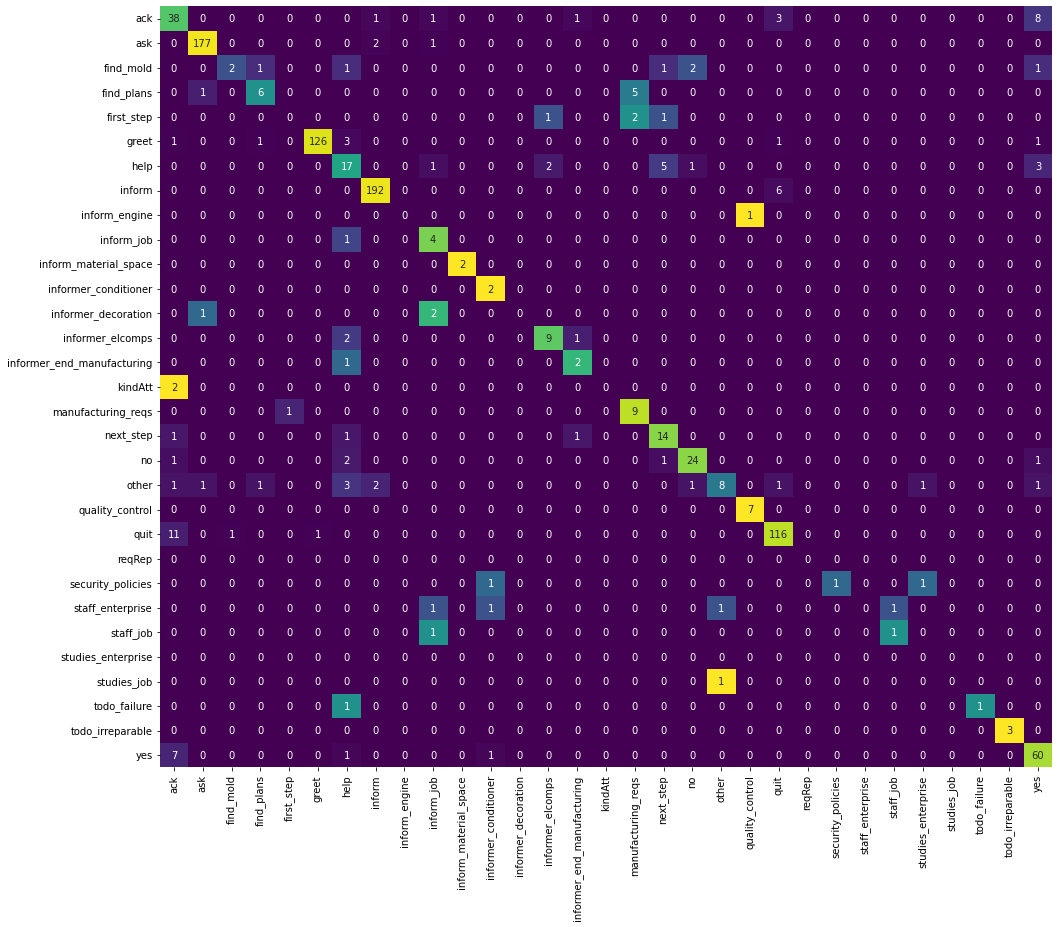

In [84]:
plot_confusion_matrix(labels, camembert_preds, label_names)

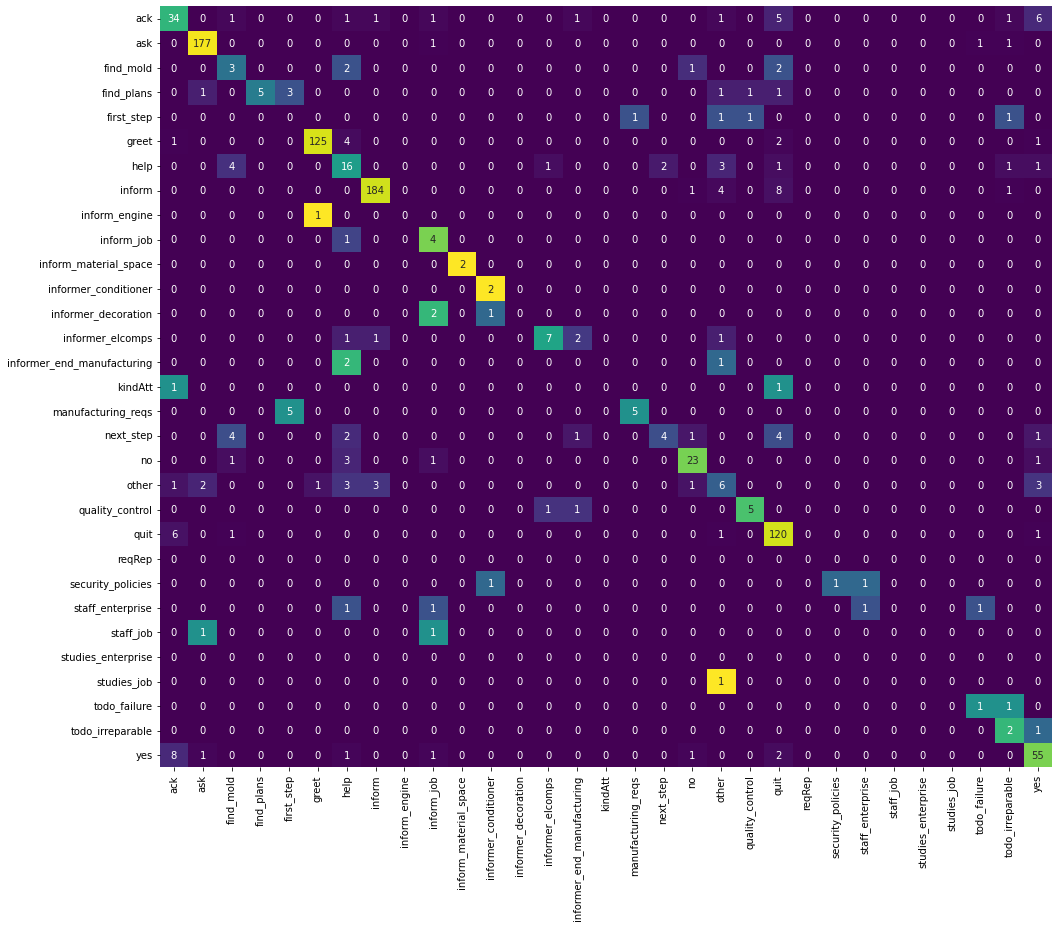

In [85]:
plot_confusion_matrix(labels, no_init_preds, label_names)